In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

from ipywidgets import FloatProgress
from IPython.display import display

import nhdspy as disp
import importlib

In [2]:
def plot_dispersion(output, ax_re, ax_imag):
    growth = output.omega_imag
    ax_re.scatter(output.kz, output.omega_real, s=10)
    
    s = ax_imag.scatter(output.kz[growth > 0], growth[growth > 0], s=10)
    ax_imag.scatter(output.kz[growth < 0], -growth[growth < 0],
                    s=10, marker='x', color=s.get_facecolors()[0], alpha=0.5)

Dispersion relation function
---
Solves a three species dispersion relation for protons, alphas, and electrons. Electrons are assumed to have
$\beta_{e} = 1$ and $\mathcal{A}_{e} = 1$ and the rest of their parameters are set to ensure no net current
and no net charge.

In [3]:
def three_species_dispersion(protons, alphas, omega_guess):
    kzmin = 1
    kzmax = 0.01
    propagation_angle = 0.00001
    va = 150 * u.km / u.s
    # Normalise to speed of light
    va = (va / const.c).to(u.dimensionless_unscaled)
    
    # Calculate electron parameters
    ne = protons.n + (2 * alphas.n)
    vd_e = (2 * (alphas.n / ne) * alphas.v_d) + (1 * (protons.n / ne) * protons.v_d)
    electrons = disp.Species(-1, 1 / 1836, ne, vd_e, 1, 1)

    species = [protons, electrons, alphas]
    # Run forwards to large numbers
    inp = disp.InputParams(species, omega_guess,
                           propagation_angle, va, kzmin, kzmax,
                           kzsteps=200, numiter=1000, n_bessel=3, det_D_threshold=1e-5)
    return disp.run(inp)

Growth rate in the $\mathcal{A} - \beta$ plane
---
This funciton calculates the growth rate across points in a beta-anisotropy plane.

In [4]:
def never_skip(ani, beta):
    return False

def growth_beta_ani(species, proton, alpha, anis, betas,
                    skip=never_skip, w_guess=0.001 + 0.001 * 1j,
                    polarisation=None):
    """
    Calculate growth rates over a range of anisotropies and betas.
    Dispersion relations start caclulating from k=1 and work their
    way linearly down to k=0.01.
    
    Paramters
    ---------
    species : str
        The species whose anisotropy and beta are varied
        to calculate growth rates. 'p' for protons or
        'a' for alphas
    proton : Species
        Proton object
    alpha : Species
        Alpha object
    anis : array
        1D array of anisotropies to sample
    betas : array
        1D array of betas to sample
    skip : function
        Takes anisotropy and beta, returns ``True`` if the point
        should be skipped, ``False`` otherwise.
    w_guess : complex
        Innitial frequency guess.
    polarisation : float
        If given, the mode is required to have this polarisiation
        when valid growth rates are selected.
    """ 
    # Empty array to contain the output growth rates
    growth = np.zeros((anis.size, betas.size)) * np.nan

    # Set up a nice progress bar
    f = FloatProgress(min=0, max=betas.size * anis.size)
    display(f)

    for i, tani in enumerate(anis):
        # Reset growth rate when anisotropy changes
        omega_guess =  w_guess
        for j, beta in enumerate(betas):
            f.value += 1

            # Manually skip some points
            if skip(tani, beta):
                continue

            if species == 'p':
                protons.t_ani = tani
                protons.beta_par = beta
            elif species == 'a':
                alphas.t_ani = tani
                alphas.beta_par = beta
            else:
                raise ValueError('species must by "a" or "p"')
                    

            # Calculate dispersion
            output = three_species_dispersion(protons, alphas, omega_guess)
            growths = output.omega_imag
            
            if polarisation is not None:
                pol = np.real(-1j * output.EyEx)
                growths = growths[np.isclose(pol, polarisation)]
            growths = growths[growths > 0]
            if growths.size:
                growth[i, j] = np.nanmax(growths)

            # Use the output of this growth rate as the guess for the next calculation
            omega_guess = output.omega_real[0] + 1j * output.omega_imag[0]
    
    return growth

Set up paramters
---

In [5]:
# Number densitites normalised to proton number density
n_alpha = 0.05

# Drift speeds as a fraction of the Alfvén speed
vd_alpha = 0.65

# Proton anisotropy and beta
p_Tani = 3
p_beta = 0.15

Calculate the alpha instability curve
---
In this case the proton paramters (anisotropy and beta) are held constant

In [6]:
# Set up particle objects
protons = disp.Species(1, 1, 0.9, 0, p_Tani, p_beta)
alphas = disp.Species(2, 4, n_alpha, vd_alpha, 1, 1)

# Range of alpha parameters to sample
anis = np.linspace(0.1, 1, 21)
betas = np.logspace(np.log10(0.05), np.log10(3), 22)

# Starting frequency guess
omega_guess = 1.5 + 0.01 * 1j

# Regions in parameter space to skip (to speed up calculations)
def skip(ani, beta):
    if beta > 0.2 and ani < 0.5:
        return True
    elif beta > 0.3 and ani < 0.65:
        return True
    return False

growth = growth_beta_ani('a', protons, alphas, anis, betas, w_guess=omega_guess, polarisation=1)

# Growth is output normalised to proton gyrofrequency;
# normalise to alpha gyrofrequency instead
growth = growth * 2

FloatProgress(value=0.0, max=462.0)

Plot results
---

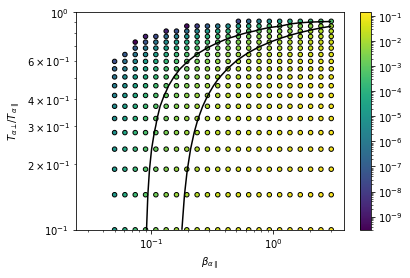

In [7]:
anis_mesh, betas_mesh = np.meshgrid(anis, betas)

fig, ax = plt.subplots()
cntr = ax.contour(betas_mesh, anis_mesh, growth.T, levels=[1e-3, 1e-2], colors='k')
s = ax.scatter(betas_mesh, anis_mesh,
               c=growth.T, s=20,
               edgecolor='k', norm=mcolor.LogNorm())
ax.set_ylim(0.1, 1)
fig.colorbar(s)
ax.set_ylabel(r'$T_{\alpha \perp} / T_{\alpha \parallel}$')
ax.set_xlabel(r'$\beta_{\alpha \parallel }$')
ax.set_xscale('log')
ax.set_yscale('log')

Save instability curves to file
---

In [8]:
for i, name in enumerate(['1e-3', '1e-2']):
    instability_data = cntr.collections[i].get_paths()[0].vertices
    np.savetxt('alpha_instability_curve_{}.csv'.format(name), instability_data)